# Entity Embedding

Traditionally categorical data has been encoded into 2 common ways:
* A label-encoder, where each unique category is assigned a unique label .
* A one hot encoding, where the categorical variable is broken into as many features as the unique number of categories for that feature and for every row, a 1 is assigned for the feature representing that row’s category and rest of the features are marked 0.

An embedding learns to map each of the unique category into a N-dimensional vector real numbers. This method was used in Kaggle competition and won the 3rd prize with relatively simple approach and was popularised in Jeremy Howard’s Fast.ai course. 
Link : https://arxiv.org/abs/1604.06737

Some of the advantages of Entity embedding :

1.  Reduces memory usage, as One-hot encoding increases the number of variables drastically.
2.  Speeds up neural network learning
3.  More importantly, mapps similar values close to each other in the embedding space revealing the intrinsic properties of the categorical variables

<img src="2.png">

__ This exercise was chosen because automotive industry includes a lot of categorical variables like car names, insurance related variables, car feature related variables __

## Code

In [1]:
import pandas as pd
import numpy as np
import keras
from fancyimpute import KNN
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

C:\Users\KumarM1\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Reading the data 
car_Data = pd.read_csv('Auto1-DS-TestData.csv')

In [3]:
# Replacing '?' with nulls#
car_Data = car_Data.replace('?', np.NaN)

In [4]:
car_Data['symboling'] = car_Data['symboling'].astype('object')
for column in ['normalized-losses','bore','stroke','peak-rpm','price','horsepower']:
    car_Data[column] = car_Data[column].astype('float')

In [5]:
# Checking for nulls
car_Data.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [6]:
num_Cols = car_Data.select_dtypes(include=['int64', 'float64']).columns
cat_Cols = car_Data.select_dtypes(include=['object']).columns

In [7]:
num_Car_Data = car_Data[num_Cols]
cat_Car_Data = car_Data[cat_Cols]

In [8]:
cat_Car_Data.loc[cat_Car_Data['num-of-doors'].isna(), 'num-of-doors'] = cat_Car_Data['num-of-doors'].mode()[0]

C:\Users\KumarM1\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\KumarM1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
# Checking for nulls
cat_Car_Data.isnull().sum()

symboling           0
make                0
fuel-type           0
aspiration          0
num-of-doors        0
body-style          0
drive-wheels        0
engine-location     0
engine-type         0
num-of-cylinders    0
fuel-system         0
dtype: int64

In [10]:
num_Car_Data = pd.DataFrame(KNN(3).fit_transform(num_Car_Data), columns=num_Cols)

Imputing row 1/205 with 1 missing, elapsed time: 0.023
Imputing row 101/205 with 0 missing, elapsed time: 0.145
Imputing row 201/205 with 0 missing, elapsed time: 0.146


In [11]:
# Checking for nulls
num_Car_Data.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_Car_Data = pd.DataFrame(scaler.fit_transform(num_Car_Data))
num_Car_Data.columns = num_Cols

In [13]:
car_Data = pd.concat([cat_Car_Data, num_Car_Data], axis = 1)

In [14]:
categorical_vars = car_Data.select_dtypes(include=['object']).columns
all_cols = car_Data.columns
other_cols = [i for i in all_cols if i not in categorical_vars ]
target = car_Data['price']

In [15]:
other_cols = other_cols[:-1]

In [16]:
def preproc(X_train ) : 

    input_list_train = []
    for c in categorical_vars :
        
        jjj = np.asarray(X_train[c].tolist())
        jjj = pd.factorize( jjj )[0]
        input_list_train.append( np.asarray(jjj)  )
        """
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        """
    #the rest of the columns
    input_list_train.append(X_train[other_cols].values)
    return input_list_train 
df_tr = preproc( car_Data )

In [17]:
from keras.layers import *
from keras.models import *

models = []

for categoical_var in categorical_vars :
    model = Sequential()
    model.reset_states( )
    no_of_unique_cat  = car_Data[categoical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    model.add(  Embedding( no_of_unique_cat+1, embedding_size, input_length = 1 ) )
    model.add(Reshape(target_shape=(embedding_size,)))
    models.append( model )


model_rest = Sequential()
model_rest.add(Dense(  64 , input_dim = 14 ))
model_rest.reset_states( )
models.append(model_rest)
 
full_model = Sequential()
full_model.add(Merge(models, mode='concat'))

full_model.add(Dense(256))
full_model.add(Activation('sigmoid'))
full_model.add(Dropout(0.2))

full_model.add(Dense(32))
full_model.add(Activation('sigmoid'))
full_model.add(Dropout(0.2))

full_model.add(Dense(1))

full_model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])


C:\Users\KumarM1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [46]:
len(full_model.get_weights())

30

In [18]:
history  =  full_model.fit( df_tr  , target  , epochs =  1500 , batch_size = 32, verbose= 1  )

Epoch 1/1500
205/205 [==============================] - 1s 5ms/step - loss: 0.9879 - mean_squared_error: 0.9879 - mean_absolute_percentage_error: 207.1612
Epoch 2/1500
205/205 [==============================] - 0s 254us/step - loss: 0.7213 - mean_squared_error: 0.7213 - mean_absolute_percentage_error: 160.5690
Epoch 3/1500
205/205 [==============================] - 0s 332us/step - loss: 0.4857 - mean_squared_error: 0.4857 - mean_absolute_percentage_error: 252.8011
Epoch 4/1500
205/205 [==============================] - 0s 156us/step - loss: 0.4252 - mean_squared_error: 0.4252 - mean_absolute_percentage_error: 280.5329
Epoch 5/1500
205/205 [==============================] - 0s 161us/step - loss: 0.4508 - mean_squared_error: 0.4508 - mean_absolute_percentage_error: 367.9762
Epoch 6/1500
205/205 [==============================] - 0s 185us/step - loss: 0.3715 - mean_squared_error: 0.3715 - mean_absolute_percentage_error: 267.3995
Epoch 7/1500
205/205 [==============================] - 0s 1

Epoch 53/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0588 - mean_squared_error: 0.0588 - mean_absolute_percentage_error: 111.7861
Epoch 54/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0634 - mean_squared_error: 0.0634 - mean_absolute_percentage_error: 93.3118
Epoch 55/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_percentage_error: 73.1738
Epoch 56/1500
205/205 [==============================] - 0s 229us/step - loss: 0.0644 - mean_squared_error: 0.0644 - mean_absolute_percentage_error: 88.1928
Epoch 57/1500
205/205 [==============================] - 0s 180us/step - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_percentage_error: 86.3384
Epoch 58/1500
205/205 [==============================] - 0s 190us/step - loss: 0.0678 - mean_squared_error: 0.0678 - mean_absolute_percentage_error: 86.0588
Epoch 59/1500
205/205 [==============================] - 

205/205 [==============================] - 0s 151us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_percentage_error: 75.0783
Epoch 106/1500
205/205 [==============================] - 0s 220us/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_percentage_error: 93.1329
Epoch 107/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0559 - mean_squared_error: 0.0559 - mean_absolute_percentage_error: 77.8626
Epoch 108/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_percentage_error: 80.9172
Epoch 109/1500
205/205 [==============================] - 0s 200us/step - loss: 0.0451 - mean_squared_error: 0.0451 - mean_absolute_percentage_error: 85.2773
Epoch 110/1500
205/205 [==============================] - 0s 239us/step - loss: 0.0582 - mean_squared_error: 0.0582 - mean_absolute_percentage_error: 59.2084
Epoch 111/1500
205/205 [==============================] - 0s 200us/

205/205 [==============================] - 0s 200us/step - loss: 0.0550 - mean_squared_error: 0.0550 - mean_absolute_percentage_error: 76.0195
Epoch 157/1500
205/205 [==============================] - 0s 263us/step - loss: 0.0621 - mean_squared_error: 0.0621 - mean_absolute_percentage_error: 84.4820
Epoch 158/1500
205/205 [==============================] - 0s 254us/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_percentage_error: 76.9717
Epoch 159/1500
205/205 [==============================] - 0s 239us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_percentage_error: 75.8362
Epoch 160/1500
205/205 [==============================] - 0s 268us/step - loss: 0.0470 - mean_squared_error: 0.0470 - mean_absolute_percentage_error: 74.6974
Epoch 161/1500
205/205 [==============================] - 0s 263us/step - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_percentage_error: 73.3315
Epoch 162/1500
205/205 [==============================] - 0s 337us/

205/205 [==============================] - 0s 122us/step - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_percentage_error: 79.8805
Epoch 208/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_percentage_error: 92.6631
Epoch 209/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0454 - mean_squared_error: 0.0454 - mean_absolute_percentage_error: 83.8273
Epoch 210/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0432 - mean_squared_error: 0.0432 - mean_absolute_percentage_error: 98.6667
Epoch 211/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0507 - mean_squared_error: 0.0507 - mean_absolute_percentage_error: 87.2647
Epoch 212/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0490 - mean_squared_error: 0.0490 - mean_absolute_percentage_error: 67.5353
Epoch 213/1500
205/205 [==============================] - 0s 166us/

205/205 [==============================] - 0s 502us/step - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_percentage_error: 82.6371
Epoch 258/1500
205/205 [==============================] - 0s 322us/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_percentage_error: 83.1878
Epoch 259/1500
205/205 [==============================] - 0s 283us/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_percentage_error: 70.2690
Epoch 260/1500
205/205 [==============================] - 0s 346us/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_percentage_error: 65.9553
Epoch 261/1500
205/205 [==============================] - 0s 259us/step - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_percentage_error: 70.1540
Epoch 262/1500
205/205 [==============================] - 0s 449us/step - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_percentage_error: 71.7979
Epoch 263/1500
205/205 [==============================] - 0s 854us/

205/205 [==============================] - 0s 156us/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_percentage_error: 56.1760
Epoch 309/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_percentage_error: 82.8966
Epoch 310/1500
205/205 [==============================] - 0s 185us/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_percentage_error: 78.1122
Epoch 311/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_percentage_error: 69.9244
Epoch 312/1500
205/205 [==============================] - 0s 171us/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_percentage_error: 70.5400
Epoch 313/1500
205/205 [==============================] - 0s 166us/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_percentage_error: 77.4884
Epoch 314/1500
205/205 [==============================] - 0s 190us/

205/205 [==============================] - 0s 415us/step - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_percentage_error: 70.5544
Epoch 360/1500
205/205 [==============================] - 0s 420us/step - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_percentage_error: 57.4437
Epoch 361/1500
205/205 [==============================] - 0s 268us/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_percentage_error: 65.1260
Epoch 362/1500
205/205 [==============================] - 0s 283us/step - loss: 0.0435 - mean_squared_error: 0.0435 - mean_absolute_percentage_error: 74.5832
Epoch 363/1500
205/205 [==============================] - 0s 400us/step - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_percentage_error: 65.0133
Epoch 364/1500
205/205 [==============================] - 0s 371us/step - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_percentage_error: 62.6004
Epoch 365/1500
205/205 [==============================] - 0s 234us/

205/205 [==============================] - 0s 180us/step - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_percentage_error: 54.4445
Epoch 410/1500
205/205 [==============================] - 0s 171us/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_percentage_error: 74.0267
Epoch 411/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_percentage_error: 71.7205
Epoch 412/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0439 - mean_squared_error: 0.0439 - mean_absolute_percentage_error: 74.5147
Epoch 413/1500
205/205 [==============================] - 0s 166us/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_percentage_error: 90.3322
Epoch 414/1500
205/205 [==============================] - 0s 166us/step - loss: 0.0446 - mean_squared_error: 0.0446 - mean_absolute_percentage_error: 75.8586
Epoch 415/1500
205/205 [==============================] - 0s 151us/

205/205 [==============================] - 0s 180us/step - loss: 0.0463 - mean_squared_error: 0.0463 - mean_absolute_percentage_error: 57.5300
Epoch 461/1500
205/205 [==============================] - 0s 200us/step - loss: 0.0471 - mean_squared_error: 0.0471 - mean_absolute_percentage_error: 75.1024
Epoch 462/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0450 - mean_squared_error: 0.0450 - mean_absolute_percentage_error: 62.2679
Epoch 463/1500
205/205 [==============================] - 0s 171us/step - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_percentage_error: 63.6131
Epoch 464/1500
205/205 [==============================] - 0s 229us/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_percentage_error: 64.5680
Epoch 465/1500
205/205 [==============================] - 0s 210us/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_percentage_error: 80.1494
Epoch 466/1500
205/205 [==============================] - 0s 195us/

205/205 [==============================] - 0s 390us/step - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_percentage_error: 54.2349
Epoch 512/1500
205/205 [==============================] - 0s 283us/step - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_percentage_error: 66.7997
Epoch 513/1500
205/205 [==============================] - 0s 190us/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_percentage_error: 76.2120
Epoch 514/1500
205/205 [==============================] - 0s 205us/step - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_percentage_error: 77.6656
Epoch 515/1500
205/205 [==============================] - 0s 244us/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_percentage_error: 75.8363
Epoch 516/1500
205/205 [==============================] - 0s 195us/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_percentage_error: 55.8143
Epoch 517/1500
205/205 [==============================] - 0s 161us/

205/205 [==============================] - 0s 137us/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_percentage_error: 68.1470
Epoch 563/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_percentage_error: 65.7938
Epoch 564/1500
205/205 [==============================] - 0s 185us/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_percentage_error: 51.8068
Epoch 565/1500
205/205 [==============================] - 0s 224us/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_percentage_error: 69.2882
Epoch 566/1500
205/205 [==============================] - 0s 234us/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_percentage_error: 73.4094
Epoch 567/1500
205/205 [==============================] - 0s 234us/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_percentage_error: 53.7001
Epoch 568/1500
205/205 [==============================] - 0s 210us/

205/205 [==============================] - 0s 137us/step - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_percentage_error: 80.9615
Epoch 614/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0459 - mean_squared_error: 0.0459 - mean_absolute_percentage_error: 68.1544
Epoch 615/1500
205/205 [==============================] - 0s 385us/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_percentage_error: 61.4310
Epoch 616/1500
205/205 [==============================] - 0s 224us/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_percentage_error: 68.1289
Epoch 617/1500
205/205 [==============================] - 0s 371us/step - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_percentage_error: 71.4435
Epoch 618/1500
205/205 [==============================] - 0s 215us/step - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_percentage_error: 57.3478
Epoch 619/1500
205/205 [==============================] - 0s 176us/

205/205 [==============================] - 0s 156us/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_percentage_error: 59.8734
Epoch 665/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_percentage_error: 69.0803
Epoch 666/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_percentage_error: 54.8043
Epoch 667/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_percentage_error: 53.6525
Epoch 668/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_percentage_error: 51.6827
Epoch 669/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_percentage_error: 55.2565
Epoch 670/1500
205/205 [==============================] - 0s 137us/

205/205 [==============================] - 0s 127us/step - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_percentage_error: 49.4314
Epoch 716/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_percentage_error: 71.7092
Epoch 717/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_percentage_error: 64.3623
Epoch 718/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_percentage_error: 59.9828
Epoch 719/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_percentage_error: 61.3975
Epoch 720/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0394 - mean_squared_error: 0.0394 - mean_absolute_percentage_error: 65.8501
Epoch 721/1500
205/205 [==============================] - 0s 137us/

205/205 [==============================] - 0s 127us/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_percentage_error: 61.5119
Epoch 767/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_percentage_error: 51.5837
Epoch 768/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_percentage_error: 57.5815
Epoch 769/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_percentage_error: 67.7924
Epoch 770/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0260 - mean_squared_error: 0.0260 - mean_absolute_percentage_error: 60.2175
Epoch 771/1500
205/205 [==============================] - 0s 127us/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_percentage_error: 46.9307
Epoch 772/1500
205/205 [==============================] - 0s 141us/

205/205 [==============================] - 0s 132us/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_percentage_error: 62.7553
Epoch 818/1500
205/205 [==============================] - 0s 127us/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_percentage_error: 63.7582
Epoch 819/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_percentage_error: 56.5318
Epoch 820/1500
205/205 [==============================] - 0s 132us/step - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_percentage_error: 58.5476
Epoch 821/1500
205/205 [==============================] - 0s 127us/step - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_percentage_error: 76.9370
Epoch 822/1500
205/205 [==============================] - 0s 132us/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_percentage_error: 53.9958
Epoch 823/1500
205/205 [==============================] - 0s 137us/

205/205 [==============================] - 0s 137us/step - loss: 0.0278 - mean_squared_error: 0.0278 - mean_absolute_percentage_error: 64.5969
Epoch 869/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_percentage_error: 56.9138
Epoch 870/1500
205/205 [==============================] - 0s 132us/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_percentage_error: 58.3431
Epoch 871/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_percentage_error: 58.8684
Epoch 872/1500
205/205 [==============================] - 0s 132us/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_percentage_error: 55.7844
Epoch 873/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_percentage_error: 55.4251
Epoch 874/1500
205/205 [==============================] - 0s 132us/

205/205 [==============================] - 0s 141us/step - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_percentage_error: 60.7455
Epoch 920/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_percentage_error: 62.6969
Epoch 921/1500
205/205 [==============================] - 0s 127us/step - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_percentage_error: 47.6001
Epoch 922/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_percentage_error: 55.9751
Epoch 923/1500
205/205 [==============================] - 0s 122us/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_percentage_error: 50.9670
Epoch 924/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_percentage_error: 66.3693
Epoch 925/1500
205/205 [==============================] - 0s 156us/

205/205 [==============================] - 0s 127us/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_percentage_error: 57.4384
Epoch 971/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_percentage_error: 64.7626
Epoch 972/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_percentage_error: 45.6408
Epoch 973/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_percentage_error: 50.6286
Epoch 974/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_percentage_error: 60.2384
Epoch 975/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_percentage_error: 52.3481
Epoch 976/1500
205/205 [==============================] - 0s 141us/

205/205 [==============================] - 0s 122us/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_percentage_error: 59.1878
Epoch 1022/1500
205/205 [==============================] - 0s 122us/step - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_percentage_error: 63.7850
Epoch 1023/1500
205/205 [==============================] - 0s 117us/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_percentage_error: 58.8293
Epoch 1024/1500
205/205 [==============================] - 0s 122us/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_percentage_error: 42.1052
Epoch 1025/1500
205/205 [==============================] - 0s 117us/step - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_percentage_error: 64.1658
Epoch 1026/1500
205/205 [==============================] - 0s 117us/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_percentage_error: 55.8689
Epoch 1027/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 122us/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_percentage_error: 67.5134
Epoch 1073/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_percentage_error: 56.6760
Epoch 1074/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_percentage_error: 69.2409
Epoch 1075/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0249 - mean_squared_error: 0.0249 - mean_absolute_percentage_error: 46.8296
Epoch 1076/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_percentage_error: 52.1913
Epoch 1077/1500
205/205 [==============================] - 0s 132us/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_percentage_error: 64.3329
Epoch 1078/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 166us/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_percentage_error: 67.8323
Epoch 1124/1500
205/205 [==============================] - 0s 263us/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_percentage_error: 54.0893
Epoch 1125/1500
205/205 [==============================] - 0s 180us/step - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_percentage_error: 65.5529
Epoch 1126/1500
205/205 [==============================] - 0s 180us/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_percentage_error: 53.5983
Epoch 1127/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_percentage_error: 51.8960
Epoch 1128/1500
205/205 [==============================] - 0s 180us/step - loss: 0.0410 - mean_squared_error: 0.0410 - mean_absolute_percentage_error: 45.8847
Epoch 1129/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 141us/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_percentage_error: 57.9059
Epoch 1175/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_percentage_error: 54.5526
Epoch 1176/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_percentage_error: 55.9509
Epoch 1177/1500
205/205 [==============================] - 0s 166us/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_percentage_error: 54.8750
Epoch 1178/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_percentage_error: 54.7903
Epoch 1179/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_percentage_error: 66.4819
Epoch 1180/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 146us/step - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_percentage_error: 57.7555
Epoch 1226/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_percentage_error: 54.6687
Epoch 1227/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0279 - mean_squared_error: 0.0279 - mean_absolute_percentage_error: 53.4432
Epoch 1228/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_percentage_error: 59.1973
Epoch 1229/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_percentage_error: 54.7178
Epoch 1230/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_percentage_error: 53.8948
Epoch 1231/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 146us/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_percentage_error: 44.7496
Epoch 1277/1500
205/205 [==============================] - 0s 166us/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_percentage_error: 54.4955
Epoch 1278/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_percentage_error: 60.9914
Epoch 1279/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0279 - mean_squared_error: 0.0279 - mean_absolute_percentage_error: 60.6761
Epoch 1280/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_percentage_error: 54.9944
Epoch 1281/1500
205/205 [==============================] - 0s 151us/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_percentage_error: 49.8966
Epoch 1282/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 156us/step - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_percentage_error: 50.7235
Epoch 1328/1500
205/205 [==============================] - 0s 180us/step - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_percentage_error: 71.5159
Epoch 1329/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_percentage_error: 55.3376
Epoch 1330/1500
205/205 [==============================] - 0s 171us/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_percentage_error: 42.5979
Epoch 1331/1500
205/205 [==============================] - 0s 171us/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_percentage_error: 47.5626
Epoch 1332/1500
205/205 [==============================] - 0s 171us/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_percentage_error: 52.8842
Epoch 1333/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 146us/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_percentage_error: 60.7558
Epoch 1379/1500
205/205 [==============================] - 0s 127us/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_percentage_error: 49.0384
Epoch 1380/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_percentage_error: 48.4666
Epoch 1381/1500
205/205 [==============================] - 0s 127us/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_percentage_error: 63.0083
Epoch 1382/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_percentage_error: 63.5498
Epoch 1383/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0253 - mean_squared_error: 0.0253 - mean_absolute_percentage_error: 59.0667
Epoch 1384/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 141us/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_percentage_error: 51.5461
Epoch 1430/1500
205/205 [==============================] - 0s 141us/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_percentage_error: 41.1358
Epoch 1431/1500
205/205 [==============================] - 0s 156us/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_percentage_error: 51.1800
Epoch 1432/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_percentage_error: 52.9062
Epoch 1433/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0428 - mean_squared_error: 0.0428 - mean_absolute_percentage_error: 60.5360
Epoch 1434/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_percentage_error: 54.0680
Epoch 1435/1500
205/205 [==============================] - 0s 

205/205 [==============================] - 0s 141us/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_percentage_error: 51.9283
Epoch 1481/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_percentage_error: 56.8603
Epoch 1482/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_percentage_error: 59.7740
Epoch 1483/1500
205/205 [==============================] - 0s 137us/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_percentage_error: 61.9161
Epoch 1484/1500
205/205 [==============================] - 0s 161us/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_percentage_error: 47.0314
Epoch 1485/1500
205/205 [==============================] - 0s 146us/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_percentage_error: 49.9138
Epoch 1486/1500
205/205 [==============================] - 0s 

In [55]:
loss = history.history['loss']
mse = history.history['mean_squared_error']
mape =  history.history['mean_absolute_percentage_error']

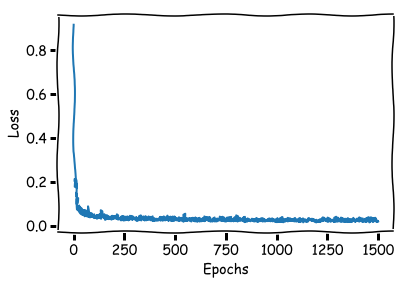

In [56]:
import  matplotlib.pyplot as plt
%matplotlib inline
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( loss  )

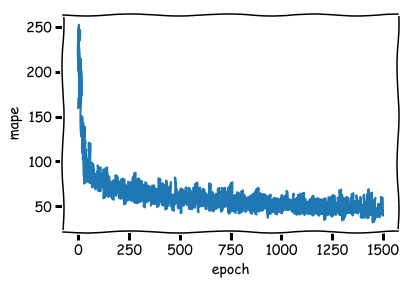

In [57]:
plt.xlabel("epoch")
plt.ylabel("mape")
plt.plot( mape )